torch.Size([1, 5, 8])


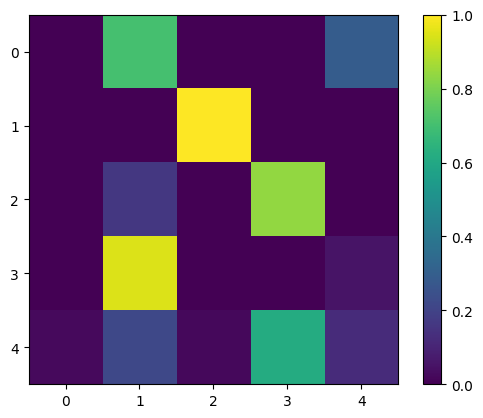

In [1]:
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt

# Input
x = torch.randn(1,5,8)

# Q K V
WQ,WK,WV = torch.randn(8,8),torch.randn(8,8),torch.randn(8,8)
Q,K,V = x@WQ, x@WK, x@WV

# Scaled Dot-Product Attention
attn = F.softmax((Q@K.transpose(-2,-1))/(8**0.5), dim=-1)
out = attn@V

print(out.shape)

# Visualize
plt.imshow(attn[0].detach().numpy())
plt.colorbar()
plt.show()


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)

    def forward(self, x):
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)

        scores = Q @ K.transpose(-2,-1) / (x.size(-1)**0.5)
        attn = F.softmax(scores, dim=-1)
        out = attn @ V
        return out, attn

# Example
x = torch.randn(1,5,8)        # (batch, seq_len, embed_dim)
sa = SelfAttention(8)
output, weights = sa(x)

print(output.shape)


torch.Size([1, 5, 8])


In [3]:
import torch, torch.nn.functional as F

# input
x = torch.randn(1,5,8)
h, dk = 2, 4

# Q K V
Wq,Wk,Wv = torch.randn(8,8),torch.randn(8,8),torch.randn(8,8)
Q = (x@Wq).view(1,5,h,dk).transpose(1,2)
K = (x@Wk).view(1,5,h,dk).transpose(1,2)
V = (x@Wv).view(1,5,h,dk).transpose(1,2)

# multi-head attention
A = F.softmax((Q@K.transpose(-2,-1))/(dk**0.5), dim=-1)
heads = A@V

print("Head1:", heads[0,0])
print("Head2:", heads[0,1])


Head1: tensor([[-2.2469, -0.2120, -0.4533, -0.2315],
        [ 4.3080, -1.0443, -3.9162, -4.1290],
        [-1.5863, -0.1707, -0.3551, -0.1864],
        [-2.2496, -0.2122, -0.4527, -0.2302],
        [ 5.0092, -1.9102, -5.4185, -5.1126]])
Head2: tensor([[ 2.9246,  2.9321, -0.0794,  1.3218],
        [ 3.8547, -0.7769,  1.3130, -3.6243],
        [ 2.8869,  3.0576, -0.1248,  1.4819],
        [-3.8868, -3.1508, -0.7922,  0.6886],
        [-0.0178,  4.1125,  0.0257,  0.7299]])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


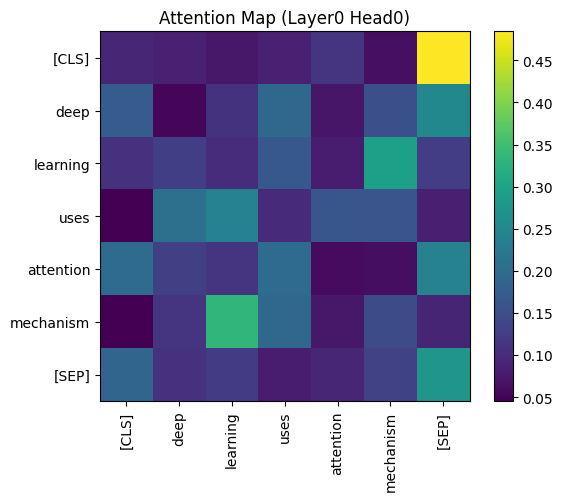

In [4]:
# pip install transformers matplotlib

import torch, matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel

tok = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True)

text = "deep learning uses attention mechanism"
inputs = tok(text, return_tensors="pt")

out = model(**inputs)
attn = out.attentions[0][0,0].detach()   # layer0, head0

plt.imshow(attn)
plt.xticks(range(len(inputs.input_ids[0])), tok.convert_ids_to_tokens(inputs.input_ids[0]), rotation=90)
plt.yticks(range(len(inputs.input_ids[0])), tok.convert_ids_to_tokens(inputs.input_ids[0]))
plt.title("Attention Map (Layer0 Head0)")
plt.colorbar()
plt.show()


In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tok = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")

inp = tok("attention heads test", return_tensors="pt")
base = model(**inp).logits

for h in range(model.config.num_attention_heads):
    mask = torch.ones(model.config.num_hidden_layers, model.config.num_attention_heads)
    mask[:,h] = 0
    diff = (base - model(**inp, head_mask=mask).logits).abs().mean()
    print("Head",h,"impact:",diff.item())


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Head 0 impact: 0.0
Head 1 impact: 0.0
Head 2 impact: 0.0
Head 3 impact: 0.0
Head 4 impact: 0.0
Head 5 impact: 0.0
Head 6 impact: 0.0
Head 7 impact: 0.0
Head 8 impact: 0.0
Head 9 impact: 0.0
Head 10 impact: 0.0
Head 11 impact: 0.0


In [6]:
import torch
import torch.nn as nn
import math

class EncoderBlock(nn.Module):
    def __init__(self, d_model=64, heads=4, ff=128):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, heads, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff), nn.ReLU(), nn.Linear(ff, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        a,_ = self.attn(x,x,x)     # self-attention
        x = self.norm1(x + a)
        f = self.ffn(x)            # feed-forward
        x = self.norm2(x + f)
        return x

# test
x = torch.randn(1,10,64)
enc = EncoderBlock()
print(enc(x).shape)


torch.Size([1, 10, 64])


In [7]:
class SinPosEnc(nn.Module):
    def __init__(self, d_model, max_len=50):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0,max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0,d_model,2)*(-math.log(10000)/d_model))
        pe[:,0::2] = torch.sin(pos*div)
        pe[:,1::2] = torch.cos(pos*div)
        self.pe = pe.unsqueeze(0)

    def forward(self,x):
        return x + self.pe[:,:x.size(1)]


In [8]:
class LearnedPosEnc(nn.Module):
    def __init__(self, max_len=50, d_model=64):
        super().__init__()
        self.emb = nn.Embedding(max_len, d_model)

    def forward(self,x):
        pos = torch.arange(x.size(1)).unsqueeze(0)
        return x + self.emb(pos)


In [ ]:
x = torch.randn(1,10,64)

sin_pe = SinPosEnc(64)
learn_pe = LearnedPosEnc()

print("Sinusoidal:", sin_pe(x).shape)
print("Learned:", learn_pe(x).shape)


In [9]:
import torch
import torch.nn as nn

# Short Transformer Encoder Block
class EncoderBlock(nn.Module):
    def __init__(self, d_model, heads, d_ff):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, heads, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        a,_ = self.attn(x, x, x)
        x = self.norm1(x + a)
        f = self.ffn(x)
        x = self.norm2(x + f)
        return x

